Modified from polychrom extrusion_1D_newCode\
Original Source : https://github.com/open2c/polychrom.git \
Licensed under MIT License\
Copyright (c) 2019 Massachusetts Institute of Technology

Many Simulations, so the Hi-C map might be distorted. For real TAD, you have to average over M independent replicates.

In [16]:
from lef_sim import translocate, loadOne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py 

In [17]:
import os 
if not os.path.exists("trajectory_20260224"):
    os.mkdir("trajectory_20260224")

In [19]:
N1 = 5000 # size of one system ~ length of a polymer
M = 10 # 10 independent replicates ~ we actually simulate this as if M sets are on the line
N = N1 * M 

LIFETIME = 200 
SEPARATION = 200
LEFNum = N // SEPARATION 
trajectoryLength = 10000

args = {}

bin_size = 50

In [20]:
ctcfLeftCapture = {50 + k*N1: 0.5 for k in range(M)}
ctcfRightCapture = {150 + k*N1: 0.5 for k in range(M)}
ctcfLeftRelease = {50 + k*N1: 0.02 for k in range(M)}  
ctcfRightRelease = {150 + k*N1: 0.02 for k in range(M)}

args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}  # this is how we feed the dictionaries of capture/release probabilities to our code 
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = 200
args["LIFETIME_STALLED"] = 10

In [21]:
occupied = np.zeros(N)
for k in range(M):
    occupied[k*N1] = 1
    occupied[(k+1)*N1 - 1] = 1
cohesins = []

for i in range(LEFNum):
    loadOne(cohesins,occupied, args)

with h5py.File("trajectory_20260224/LEFPositions.h5", mode='w') as myfile: #if no LEFPositions.h5 --> creates one and writes / else : overwrites
    
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")

    save_steps = 50 
    bins = np.linspace(0, trajectoryLength, save_steps + 1, dtype=int)
    
    for st, end in zip(bins[:-1], bins[1:]):
        cur = np.zeros((end - st, LEFNum, 2), dtype=np.int32)
        for i in range(st, end):
            translocate(cohesins, occupied, args)
            for j in range(min(len(cohesins), LEFNum)):
                cur[i - st, j, 0] = cohesins[j].left.pos
                cur[i - st, j, 1] = cohesins[j].right.pos
        
        dset[st:end] = cur
        
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum

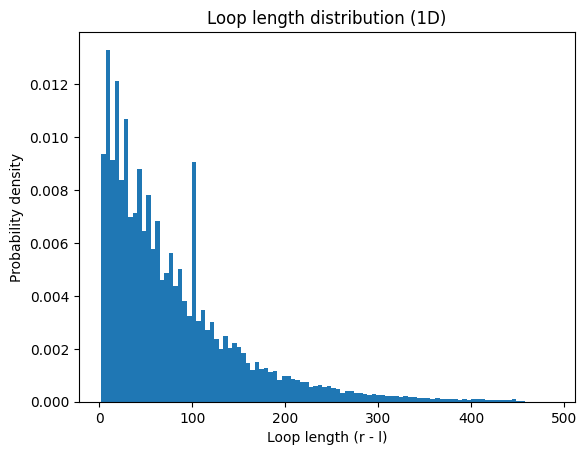

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("trajectory/LEFPositions.h5", "r") as f:
    positions = f["positions"][:]

loop_lengths = positions[:,:,1] - positions[:,:,0]
loop_lengths = loop_lengths.flatten()

plt.hist(loop_lengths, bins=100, density=True)
plt.xlabel("Loop length (r - l)")
plt.ylabel("Probability density")
plt.title("Loop length distribution (1D)")
plt.show()

#loop length = | r - l |

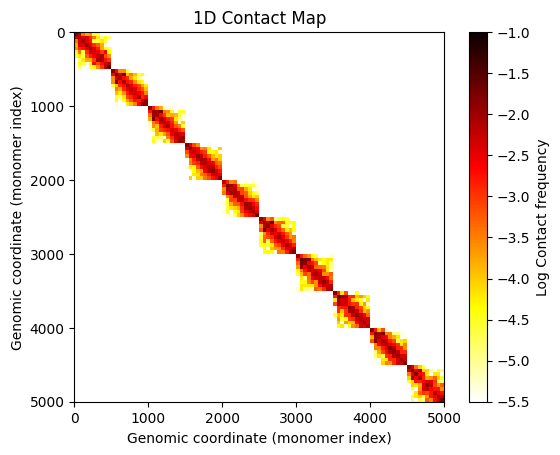

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

steps = 25
#make the contact map

with h5py.File("trajectory/LEFPositions.h5", "r") as f:
    positions = f["positions"][:]
    N = f.attrs["N"]

cmap = np.zeros((N, N), dtype=np.float32)

for t in range(0, len(positions), steps):
    for l, r in positions[t]:
        cmap[l, r] += 1
        cmap[r, l] += 1
#contact of left & right --> contact! (we somehow ignored the loop between r and l)

#update the Hi-C contact map

cmap /= (len(positions) / steps)

Nb = N // bin_size
cmap_binned = cmap.reshape(Nb, bin_size, Nb, bin_size).sum(axis=(1,3))

extent = [0, N, N, 0]

plt.figure()

res = np.log(cmap_binned+1e-6)

plt.imshow(res,
           cmap="hot_r",
           extent=extent,
           vmin = -5.5,
           vmax = -1,)
plt.title("1D Contact Map")
plt.xlabel("Genomic coordinate (monomer index)")
plt.ylabel("Genomic coordinate (monomer index)")
plt.colorbar(label="Log Contact frequency")

plt.show()

Be careful when analyzing the result. This is not a long chromosome, but M independent polymers with length of N1.

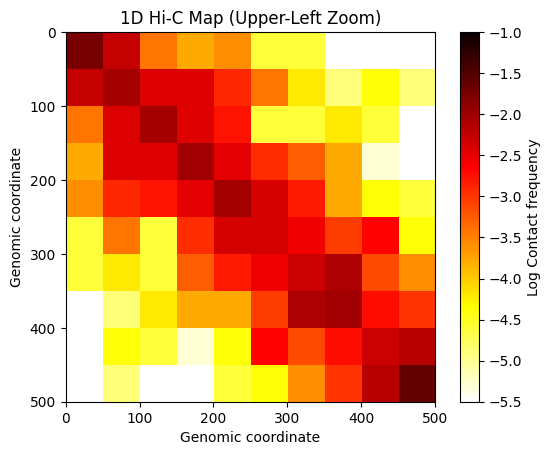

In [8]:
res_sub = res[:int(N1/bin_size), :int(N1/bin_size)]

view_limit_genomic = N1
extent_sub = [0, view_limit_genomic, view_limit_genomic, 0]

plt.figure()

plt.imshow(res_sub,
           cmap="hot_r",
           extent=extent_sub,
           vmin=-5.5,
           vmax=-1)

plt.title("1D Hi-C Map (Upper-Left Zoom)")
plt.xlabel("Genomic coordinate")
plt.ylabel("Genomic coordinate")
plt.colorbar(label="Log Contact frequency")

plt.show()

Due to the binning process, you have to be careful when zooming the TADs!